Using device: cpu
Using model: mrm8488/spanbert-finetuned-squadv2

PREPROCESSING DATA
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)


Some weights of the model checkpoint at mrm8488/spanbert-finetuned-squadv2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Example 0:
  True label: Unambiguous
  Num candidates: 4
  Max prob: 0.962
  Entropy: 0.140
  Top2 ratio: 0.024
  Prob gap: 0.939

Example 1:
  True label: Unambiguous
  Num candidates: 8
  Max prob: 0.909
  Entropy: 0.181
  Top2 ratio: 0.071
  Prob gap: 0.845

Example 2:
  True label: Ambiguous
  Num candidates: 20
  Max prob: 0.846
  Entropy: 0.165
  Top2 ratio: 0.161
  Prob gap: 0.710

Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.461
  Validation F1 (Ambiguous): 0.6500

Random Forest:
  Best Threshold: 0.401
  Validation F1 (Ambiguous): 0.6829

SVM (Linear Kernel):
  Best Threshold: 0.425
  Validation F1 (Ambiguous): 0.6500

Naive Bayes:
  Best Threshold: 0.232
  Validation F1 (Ambiguous): 0.6667

KNN (k=5):
  Best Threshold: 0.600
  Validation F1 (Ambiguous): 0.6471

Gradient Boosting:
  Best Threshold: 0.224
  Validation F1 (Ambiguous): 0.7000

AdaBoost:
  Best Threshold: 0.454
  Validation F1 (Ambiguous): 0.6154

Selected Model: Gradient Boosting
Optimized Threshold: 0.224

STEP 3: Final Test Evaluation (Optimized)


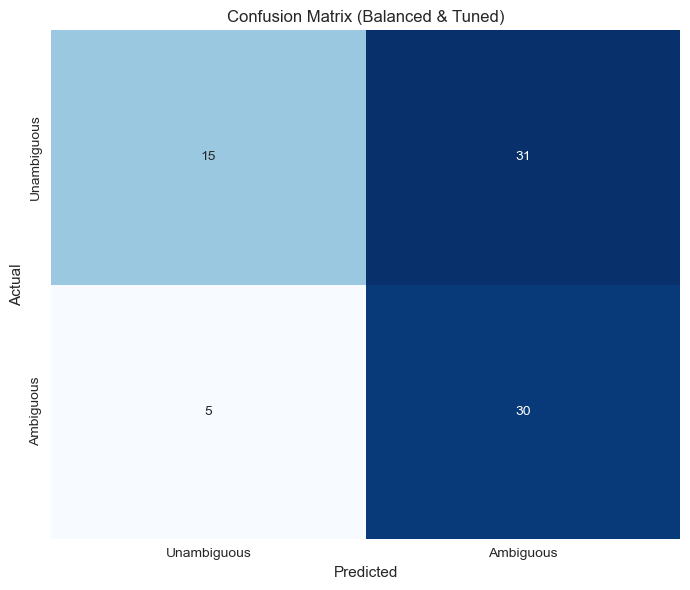


CLASSIFICATION REPORT  (Balanced & Tuned)
              precision    recall  f1-score   support

 Unambiguous     0.7500    0.3261    0.4545        46
   Ambiguous     0.4918    0.8571    0.6250        35

    accuracy                         0.5556        81
   macro avg     0.6209    0.5916    0.5398        81
weighted avg     0.6384    0.5556    0.5282        81



In [18]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding

import os
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve,
                             precision_recall_fscore_support, accuracy_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_spanbert_input_new.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)


# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))
    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start)
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df


# -------------------------
# Candidate Extraction
# -------------------------
# Create candidate spans from NOUN/PROPN tokens with optional left expansion
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)
    
    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))
            
            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break
            
            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))
    
    return spans

# Multi-source candidate extraction
def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallback: nearest NOUN/PROPN
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok
        
        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx), 
                'end': int(nearest.idx + len(nearest.text)), 
                'text': nearest.text
            })
        else:
            # Extreme fallback: content words only
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx), 
                            'end': int(tok.idx + len(tok.text)), 
                            'text': tok.text
                        })
                        break

    return candidates


# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long)
        }


# -------------------------
# Alignment
# -------------------------
# Align character spans to token indices
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i
    
    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None


# -------------------------
# Feature Extraction
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    """
    Extract features from QA model for classification.
    
    Features:
    1. max_prob: highest candidate probability (high = one clear winner)
    2. entropy: entropy of distribution (high = ambiguous)
    3. num_candidates: total candidates
    4. top2_ratio: ratio of 2nd to 1st probability (high = ambiguous)
    5. mean_prob: average probability
    6. prob_gap: difference between top 2 probabilities (high = unambiguous)
    """
    model.eval()
    model.to(device)
    
    all_features = []
    all_labels = []
    no_candidates_count = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, 
                          token_type_ids=token_type_ids)
            start_logits_batch = outputs.start_logits
            end_logits_batch = outputs.end_logits

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')
                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)
                candidate_score_tensors = []

                if candidates:
                    start_logits = start_logits_batch[i]
                    end_logits = end_logits_batch[i]
                    for cand in candidates:
                        s_rel = int(cand['start'])
                        e_rel = int(cand['end'])
                        start_token_idx, end_token_idx = align_span_to_token_indices(
                            s_rel, e_rel, offmap, tt
                        )
                        if start_token_idx is None or end_token_idx is None:
                            continue
                        s_logit = start_logits[start_token_idx]
                        e_logit = end_logits[end_token_idx]
                        span_score = s_logit + e_logit
                        candidate_score_tensors.append(span_score)

                # Compute features
                if not candidate_score_tensors or len(candidate_score_tensors) == 0:
                    no_candidates_count += 1
                    features = [0.0, 0.0, 0, 0.0, 0.0, 0.0]
                else:
                    scores_tensor = torch.stack(candidate_score_tensors)
                    probs = torch.softmax(scores_tensor, dim=0).cpu().numpy()
                    
                    # Feature 1: Max probability
                    max_prob = float(np.max(probs))
                    
                    # Feature 2: Entropy (normalized)
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    
                    # Feature 3: Number of candidates
                    num_candidates = len(probs)
                    
                    # Feature 4: Top-2 ratio
                    sorted_probs = np.sort(probs)[::-1]
                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                    else:
                        top2_ratio = 0.0
                    
                    # Feature 5: Mean probability
                    mean_prob = float(np.mean(probs))
                    
                    # Feature 6: Probability gap (top1 - top2)
                    if len(sorted_probs) >= 2:
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        prob_gap = 1.0  # Only one candidate = maximum gap
                    
                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap]
                
                # Verbose output for first few examples
                if verbose and batch_idx == 0 and i < 3:
                    label_i = int(labels[i].item())
                    print(f"\nExample {i}:")
                    print(f"  True label: {'Ambiguous' if label_i == 1 else 'Unambiguous'}")
                    print(f"  Num candidates: {features[2]}")
                    if features[2] > 0:
                        print(f"  Max prob: {features[0]:.3f}")
                        print(f"  Entropy: {features[1]:.3f}")
                        print(f"  Top2 ratio: {features[3]:.3f}")
                        print(f"  Prob gap: {features[5]:.3f}")
                
                all_features.append(features)
                all_labels.append(int(labels[i].item()))
    
    if no_candidates_count > 0:
        print(f"  Note: {no_candidates_count} instances had no aligned candidates")
    
    return np.array(all_features), np.array(all_labels)


# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    """Train a classifier with class weighting and threshold tuning."""
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)
    
    # 1. Use class_weight='balanced' to punish missing Ambiguous cases
    classifiers = {
        'Logistic Regression': LogisticRegression(
            random_state=RANDOM_SEED,
            max_iter=1000,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED,
            max_depth=5,
            class_weight='balanced'
        ),
        'SVM (Linear Kernel)': SVC(
            kernel='linear',
            probability=True,
            class_weight='balanced',
            random_state=RANDOM_SEED
        ),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(
            n_neighbors=5
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        )
    }
    
    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""
    
    for name, clf in classifiers.items():
        # Train
        clf.fit(train_features, train_labels)
        
        # Get probabilities instead of hard predictions
        val_probs = clf.predict_proba(val_features)[:, 1]
        
        # 2. Dynamic Threshold Tuning
        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
        
        # Calculate F1 for every possible threshold
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx]
        current_best_f1 = f1_scores[best_idx]
        
        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")
        
        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name
    
    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")
    
    return best_clf, best_threshold

# -------------------------
# Evaluation
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))


# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)
    
    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)
    
    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)
    
    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)
    
    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)


    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation (Optimized)\n" + "=" * 60)
    
    # Get probabilities for test set
    test_probs = classifier.predict_proba(test_features)[:, 1]
    
    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)
    
    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" (Balanced & Tuned)")


---